## 1. Importing Necessary Libraries ##

In [ ]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation , Embedding, GlobalMaxPooling1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13567604012927872816
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11002598177651346347
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15797995217859617183
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13345197979674989013
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## 2. Reading and Visualization of the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
main_directory = '/content/drive/My Drive/My Works/Bangla YouTube/Emotion.csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

nltk_stop_words = '/content/drive/My Drive/Thesis/Thesis Codes 4_2/Dataset/stopwords.bangla.dat'

In [ ]:
dataset = pd.read_csv(main_directory,encoding = 'utf-8',sep=';')
dataset.head()

,id,text,emotion,lan,domain
0,2275,Hands down. You are good. I mean smart good.,joy,EN,funny_video
1,2283,Your are very good. keep it up,none,EN,funny_video
2,2292,Man!! I will never get used to these videos of...,surprise,EN,funny_video
3,2293,ডিসলাইক দেয়া 32,none,BN,funny_video
4,2298,ব্যাপক বিনোদন।,joy,BN,funny_video


In [ ]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,id,text,emotion,lan,domain
0,17078,there is no language to express about this i c...,none,EN,drama_video
1,20893,gf thakle evabei rasta par\n,none,RN,funny_video
2,26564,সবই ঠিক আছে কিন্তু নুসরাত ফারিয়া ক্যান ভাই? এই...,disgust,BN,music_video
3,25376,দুই মাগীরে জোতা দিয়া পিঠানো হোক।\n,anger,BN,talkshow_video
4,21331,salman wow\n,joy,EN,funny_video


In [ ]:
# Get indexes where lan column has value EN and BN
indexNames = dataset[(dataset['lan'] == 'EN') | (dataset['lan'] == 'BN')].index

# Delete these row indexes from dataFrame
dataset = dataset.drop(indexNames)

In [ ]:
dataset.head()

,id,text,emotion,lan,domain
1,20893,gf thakle evabei rasta par\n,none,RN,funny_video
5,13088,Lg Q6 chai\n,none,RN,review_video
7,15929,eni toh shari porte jane naa abar bole roj off...,surprise,RN,drama_video
8,22543,lol I love your videos! please be active again...,joy,RN,funny_video
11,21061,"ভয়ে ছিল, যদি মোবাইলটা ভেঙে যায়!😂😂\n",fear,RN,funny_video


In [ ]:
emotion = np.array(dataset['emotion'])

In [ ]:
class_values = dataset['emotion'].unique()
print(class_values)

['none' 'surprise' 'joy' 'fear' 'disgust' 'anger' 'sad' 'others']


In [ ]:
dataset.groupby('emotion')['text'].count()

emotion
anger       116
disgust     225
fear          5
joy         349
none        315
others        2
sad          72
surprise     53
Name: text, dtype: int64

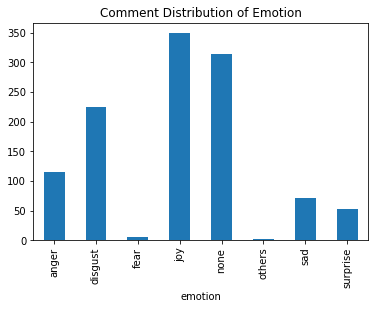

In [ ]:
dataset.groupby('emotion')['text'].count().plot(kind='bar' , title= 'Comment Distribution of Emotion')

In [ ]:
dataset['text']
dataset.head()

,id,text,emotion,lan,domain
1,20893,gf thakle evabei rasta par\n,none,RN,funny_video
5,13088,Lg Q6 chai\n,none,RN,review_video
7,15929,eni toh shari porte jane naa abar bole roj off...,surprise,RN,drama_video
8,22543,lol I love your videos! please be active again...,joy,RN,funny_video
11,21061,"ভয়ে ছিল, যদি মোবাইলটা ভেঙে যায়!😂😂\n",fear,RN,funny_video


In [ ]:
def plot_model(history):
    # Plot training & validation accuracy values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy',linewidth=3.0)
    plt.plot(x, val_acc, 'r', label='Validation accuracy',linewidth=3.0)
    plt.title('Training and validation accuracy',fontsize=18)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss',linewidth=3.0)
    plt.plot(x, val_loss, 'r', label='Validation loss',linewidth=3.0)
    plt.title('Training and validation loss', fontsize=18)
    plt.legend()


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


## 3. Label Encoding & Vectorization


In [ ]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(emotion)

print(label_encoder.classes_)

label_OneHotEncoder = OneHotEncoder()
encoded_label = label_OneHotEncoder.fit_transform(encoded_label.reshape(-1,1)).toarray()

['anger' 'disgust' 'fear' 'joy' 'none' 'others' 'sad' 'surprise']


In [ ]:
vocabulary_size = 10000
input_length = 30

In [ ]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])
data = pad_sequences(sequences, maxlen = input_length)

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(data, encoded_label, test_size = 0.2)

In [ ]:
num_classes = len(class_values)
validation_split = 0.1

# 4. Model Creation & Training

# LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000


validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,activation='relu'))
model_lstm.add(Dense(num_classes, activation='softmax'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 1000)          10000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               440400    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 808       
Total params: 10,441,208
Trainable params: 10,441,208
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_lstm.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, batch_size=4,
                    shuffle = True, callbacks = callback)

Epoch 1/100
182/182 [==============================] - 53s 289ms/step - loss: 0.3238 - accuracy: 0.3439 - f1_m: 0.0403 - precision_m: 0.0778 - recall_m: 0.0288 - val_loss: 0.3274 - val_accuracy: 0.4396 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
182/182 [==============================] - 52s 288ms/step - loss: 0.2404 - accuracy: 0.6327 - f1_m: 0.3741 - precision_m: 0.5934 - recall_m: 0.2940 - val_loss: 0.2990 - val_accuracy: 0.4615 - val_f1_m: 0.4195 - val_precision_m: 0.5833 - val_recall_m: 0.3424
Epoch 3/100
182/182 [==============================] - 52s 286ms/step - loss: 0.1190 - accuracy: 0.8088 - f1_m: 0.7623 - precision_m: 0.8942 - recall_m: 0.6896 - val_loss: 0.3200 - val_accuracy: 0.5000 - val_f1_m: 0.4377 - val_precision_m: 0.6322 - val_recall_m: 0.3478
Epoch 4/100
182/182 [==============================] - 52s 285ms/step - loss: 0.0749 - accuracy: 0.8941 - f1_m: 0.8673 - precision_m: 0.9258 - recall_m: 0.8292 - val_loss: 0.3489

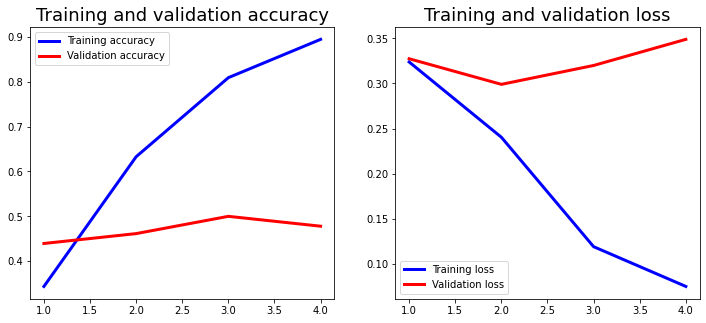

In [ ]:
plot_model(history)

In [ ]:
model_lstm.evaluate(test_data, test_label, verbose = 1)

8/8 [==============================] - 0s 30ms/step - loss: 0.3784 - accuracy: 0.4430 - f1_m: 0.3580 - precision_m: 0.4941 - recall_m: 0.2812


[0.3783661425113678,
 0.4429824650287628,
 0.35803860425949097,
 0.49405959248542786,
 0.28125]

In [ ]:
model_lstm.save('/content/drive/My Drive/My Works/Bangla YouTube/model_lstm_banglish.h5')

# Stacked LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 128
l2_lstm_units = 64

validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model = Sequential()

model.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model.add(Dense(dense_input, activation='tanh'))

model.add(LSTM(l1_lstm_units, dropout = l1_dropout, recurrent_dropout = l1_recurrent_dropout, 
                             return_sequences = True, activation='tanh'))
model.add(LSTM(l2_lstm_units, dropout = l2_dropout, recurrent_dropout = l2_recurrent_dropout, 
                             return_sequences = False, activation='tanh'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 1000)          10000000  
_________________________________________________________________
dense_4 (Dense)              (None, 30, 1000)          1001000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           578048    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 11,628,976
Trainable params: 11,628,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, batch_size=4,
                    shuffle = True, callbacks = callback)



Epoch 1/100
182/182 [==============================] - 82s 453ms/step - loss: 0.3051 - accuracy: 0.3686 - f1_m: 0.0923 - precision_m: 0.1859 - recall_m: 0.0646 - val_loss: 0.2728 - val_accuracy: 0.4670 - val_f1_m: 0.2849 - val_precision_m: 0.5362 - val_recall_m: 0.2011
Epoch 2/100
182/182 [==============================] - 81s 443ms/step - loss: 0.1906 - accuracy: 0.6850 - f1_m: 0.6295 - precision_m: 0.7766 - recall_m: 0.5517 - val_loss: 0.3046 - val_accuracy: 0.4835 - val_f1_m: 0.4059 - val_precision_m: 0.5652 - val_recall_m: 0.3315
Epoch 3/100
182/182 [==============================] - 80s 441ms/step - loss: 0.1476 - accuracy: 0.7510 - f1_m: 0.7345 - precision_m: 0.8306 - recall_m: 0.6754 - val_loss: 0.3475 - val_accuracy: 0.4396 - val_f1_m: 0.4175 - val_precision_m: 0.5000 - val_recall_m: 0.3750


In [ ]:
model.evaluate(test_data, test_label, verbose = 1)

8/8 [==============================] - 0s 42ms/step - loss: 0.3658 - accuracy: 0.4035 - f1_m: 0.3837 - precision_m: 0.4383 - recall_m: 0.3438


[0.36578699946403503,
 0.4035087823867798,
 0.3837396204471588,
 0.4383447766304016,
 0.34375]

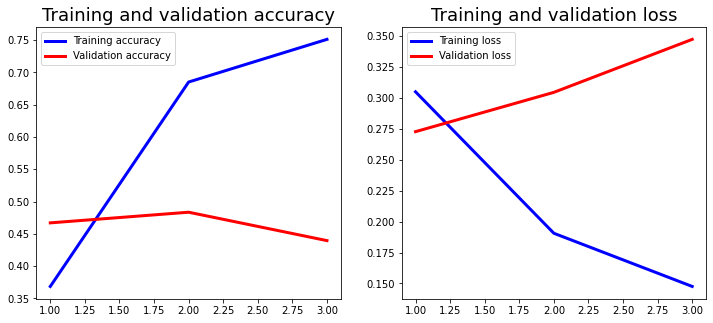

In [ ]:
plot_model(history)

In [ ]:
model.save('/content/drive/My Drive/My Works/Bangla YouTube/model_stacked_lstm_banglish.h5')

# Stacked LSTM with CNN using pre-trained word embeddings

In [ ]:
glove_dir =  '/content/drive/My Drive/Thesis/Thesis Codes 4_2/Dataset/bn_glove.100d.txt'

In [ ]:
output_dim=100

In [ ]:
embeddings_index = dict()
f = open(glove_dir, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((vocabulary_size, output_dim))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 4

pool_size = 5

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

In [ ]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, output_dim, input_length = input_length, 
                          weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(dropout))

model_glove.add(Dense(output_dim, activation='tanh'))

model_glove.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, 
                       activation='tanh'))
model_glove.add(MaxPooling1D(pool_size = pool_size))

model_glove.add(LSTM(l1_lstm_units , dropout = l1_dropout,
                     return_sequences=True, activation='tanh'))
model_glove.add(LSTM(l2_lstm_units , dropout = l2_dropout,
                     return_sequences=False , activation='tanh'))

model_glove.add(Dense(8, activation='softmax'))

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model_glove.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 30, 100)           10100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 100)           40100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 100)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 64)             42240     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)               

Epoch 1/100
21/21 [==============================] - 1s 63ms/step - loss: 0.3532 - accuracy: 0.2659 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3285 - val_accuracy: 0.2919 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.3208 - accuracy: 0.3048 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3175 - val_accuracy: 0.2981 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.3146 - accuracy: 0.2986 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3122 - val_accuracy: 0.2857 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 0.3114 - accuracy: 0.3235 - f1_m: 0.0000e+00 - precision

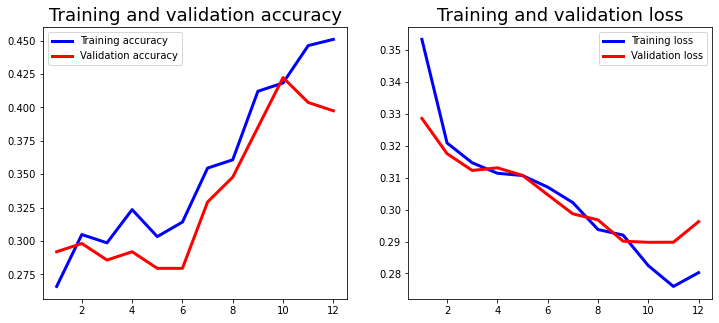

In [ ]:
history = model_glove.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, 
                          shuffle = True, callbacks = callback)

plot_model(history)

In [ ]:
model_glove.save('/content/drive/My Drive/My Works/Bangla YouTube/model_stacked_lstm_pretrained_bangla.h5')

In [ ]:
model_glove.evaluate(test_data, test_label, verbose = 1)

7/7 [==============================] - 0s 9ms/step - loss: 0.3058 - accuracy: 0.3515 - f1_m: 0.1970 - precision_m: 0.5446 - recall_m: 0.1223


[0.305764377117157,
 0.35148516297340393,
 0.19695304334163666,
 0.5445578694343567,
 0.12232142686843872]

## 5. Testing the all the above models with a random text

In [ ]:
test_text = 'faltu'
test_text = pd.Series(test_text)

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen = input_length)

In [ ]:
label_encoder.classes_[np.argmax(model_lstm.predict(data))]

'disgust'

In [ ]:
label_encoder.classes_[np.argmax(model.predict(data))]

'disgust'

In [ ]:
label_encoder.classes_[np.argmax(model_lstm.predict(data))]

'disgust'

In [ ]:
print(label_encoder.classes_)

['anger' 'disgust' 'fear' 'joy' 'none' 'others' 'sad' 'surprise']


In [ ]:
np.around(model.predict(data), decimals = 2)

array([[0.  , 0.  , 0.  , 0.93, 0.03, 0.  , 0.  , 0.02]], dtype=float32)

In [ ]:
np.around(model_lstm.predict(data), decimals = 2)

array([[0.06, 0.39, 0.02, 0.17, 0.11, 0.  , 0.15, 0.09]], dtype=float32)